# Hydrogen desorption rate calculation

Suitable for TDS (beta) measurement files

https://www.youtube.com/watch?v=kphSr36HedE

In [53]:
import numpy as np
import tkinter as tk
from tkinter import filedialog
from scipy import interpolate
import matplotlib.pyplot as plt

In [73]:
# INPUT PARAMETERS

# Number of data points at the beginning of the spectra to remove
bad_data = 30 

# Order number of specimen slot in the TDS machine
specimen_number = 1 

# Path to background data file
path_BG = "C:\\Users\\user\\Documents\\TDS data\\TDS BG\\empty_%s_090821.txt" % (specimen_number) 

# Specimen weight (Specify as None to collect the value from the measurement data file. 
# Specify the number here if data file does not have the specimen weight information or the information is incorrect.)
weight = None # units: gramm

# Heating rate during measurement
h = 10 # unit: K/min

# Calibration constant value
S = 87e-2

# Atomic weight of the studied material
am = 56.71 # for steel
#am = 47.867 # for titanium
#am = 91.224 # for zirconium

# Output file name (Specify as None to have the name similar to input file name like "input_file _name_rec.txt").
# Otherwise, specify the new name in string format like 'new_name'.)
outfile_name = None

# Hydrogen concentration unit (Specify 'wt' for wt.ppm, or 'at' for at.ppm)
H_content_unit = 'wt'

# Output file path (Specify as None to use the input file directory. 
# Specify unique directory if necessary (example: "C:\\Users\\user\\Documents\\TDS data\\TDS recalculated\\"))
# remember to use quotes when specify the unique path
pathfile = None

# Temperature unit (Specify 'K' for Kelvin, or 'C' for Celsius)
temperature_unit = 'K'

In [74]:
# IMPORT BACKGROUND DATA

x_bg = np.loadtxt(path_BG, usecols = (1)).copy()
y_bg = np.loadtxt(path_BG, usecols = (2)).copy()
if temperature_unit == 'C':
    x_bg = x_bg[bad_data:]
elif temperature_unit == 'K':
    x_bg = x_bg[bad_data:] + 273
else: 
    x_bg = x_bg[bad_data:] + 273
    temperature_unit = 'K'
    print('Temperature unit specifyed incorrectly! Kelvin considered by default')
y_bg = y_bg[bad_data:]

In [75]:
# IMPORT MEASUREMENT DATA

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

file_path = filedialog.askopenfilename(parent=root)
if file_path == '':
    print('The file path is not selected!')
else:
    x_file = np.loadtxt(file_path, usecols = (1)).copy()
    y_file = np.loadtxt(file_path, usecols = (2)).copy()
    if temperature_unit == 'C':
        x_file = x_file[bad_data:]
    elif temperature_unit == 'K':
        x_file = x_file[bad_data:] + 273.15
    y_file = y_file[bad_data:]
    if weight == None:
        weight = np.loadtxt(file_path, usecols = (6)).copy()[0]

In [76]:
# DEFINE THE OUTPUT FILE NAME

if outfile_name == None:
    for i, symbol in enumerate(reversed(file_path.split('/')[-1])):
        if symbol == '.':
            outfile_name = file_path.split('/')[-1][:-(i+1)] + '_rec'
            break
print('The output file name is: ' + outfile_name)

The output file name is: Ti_H_11_rec


In [77]:
# DEFINE OUTPUT DIRECTORY

if pathfile == None:
    for i, symbol in enumerate(reversed(file_path)):
        if symbol == '/':
            pathfile = file_path[:-i]
            break
print('The output directory is: ' + pathfile)

The output directory is: C:/Users/user/Documents/TDS_temperature_calibration/Ti/TDS/


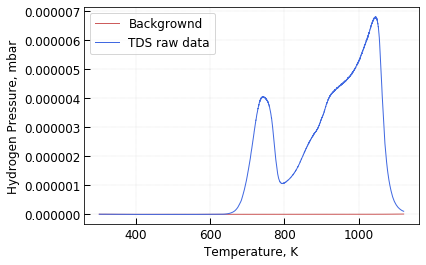

In [78]:
# SUBSTRUCT BASELINE

min_s = np.min(x_file)
max_s = np.max(x_file)
min_bg = np.min(x_bg)
max_bg = np.max(x_bg)
L = max(min_s, min_bg)
H = min(max_s, max_bg)

temperature = np.arange(L, H, 0.1)
f_bg = interpolate.interp1d(x_bg, y_bg)
y_bg_int = f_bg(temperature)
f_file = interpolate.interp1d(x_file,y_file)
y_file_int = f_file(temperature)

pressure = y_file_int - y_bg_int
pressure[pressure<0]=0

# plot the backgrownd and raw TDS spectra
plt.plot(temperature, y_bg_int, 'k-', label='Backgrownd', linewidth=1, color='indianred')
plt.plot(temperature, y_file_int, 'b-', label='TDS raw data', linewidth=1, color='royalblue')

plt.tick_params(direction='in', length=6, width=1, colors='k',
               grid_color='k', grid_alpha=0.5, labelsize= 12)
plt.grid(color='k', linestyle=':', linewidth=0.2)
plt.xlabel('Temperature, ' + temperature_unit, fontsize=12)
plt.ylabel('Hydrogen Pressure, mbar', fontsize=12)
plt.legend(fontsize=12, loc='best')

plt.savefig(pathfile+f"{outfile_name}_BG.jpg", dpi=1200, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

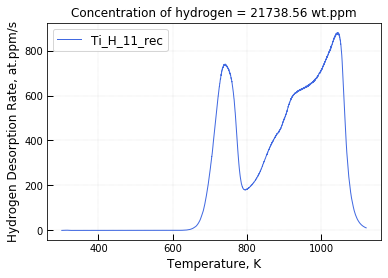

In [79]:
# HYDROGEN THERMAL DESORPTION RATE CALCULATION

if temperature_unit == 'C':
    H_flow = (((pressure*100/1.6e-19)*S)/(8.617343e-5*(temperature + 273))/(weight/(am*1.66054e-24)))*1e6
else: H_flow = (((pressure*100/1.6e-19)*S)/(8.617343e-5*(temperature))/(weight/(am*1.66054e-24)))*1e6

if H_content_unit == 'wt':
    concentration = ((1/(h/60))*np.trapz(H_flow, temperature))/am
elif H_content_unit == 'at':
    concentration = (1/(h/60))*np.trapz(H_flow, temperature)
else:
    concentration = (1/(h/60))*np.trapz(H_flow, temperature)
    H_content_unit = 'at'
    print('The hydrogen content unit specifyed incorrectly! at.ppm considered by default.')
    

# plot the result
plt.plot(temperature, H_flow, 'b-', label=outfile_name, linewidth=1, color='royalblue')
plt.tick_params(direction='in', length=6, width=1, colors='k',
               grid_color='k', grid_alpha=0.5)
plt.grid(color='k', linestyle=':', linewidth=0.2)
plt.xlabel('Temperature, ' + temperature_unit, fontsize=12)
plt.ylabel('Hydrogen Desorption Rate, at.ppm/s', fontsize=12)
plt.title(r'Concentration of hydrogen = %s '%np.round(concentration, decimals=2) + H_content_unit + '.ppm', fontsize=12)
plt.legend(fontsize=12, loc='best')

plt.savefig(pathfile+"%s.jpg" % (outfile_name), dpi=1200, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

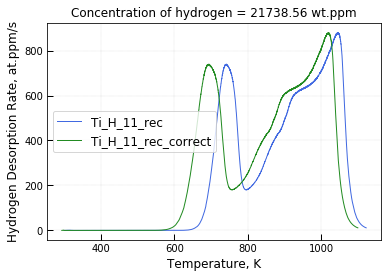

In [80]:
# TEMPERATURE CORRECTION

z = {2: np.array([ 2.42772706e-22, -1.07539777e-18,  2.02654545e-15, -2.11760839e-12,
        1.33976676e-09, -5.25394593e-07,  1.25270337e-04, -1.70001838e-02,
        1.14685596e+00, -1.71201155e+01]),
    4: np.array([-5.47835062e-15,  1.75387855e-11, -2.25073232e-08,  1.46809830e-05,
       -5.02541593e-03,  7.96648285e-01, -1.38512449e+01]),
    6: np.array([ 2.50395026e-12, -7.80481534e-09,  9.13398630e-06, -4.85144633e-03,
        1.05700428e+00, -2.25446424e+01]),
    8: np.array([ 3.34959465e-15, -8.52518628e-12,  5.97805883e-09,  1.18184608e-06,
       -2.87774011e-03,  9.33743477e-01, -2.20326058e+01]),
    10: np.array([ 6.42485190e-15, -1.92917125e-11,  2.02128112e-08, -7.49022812e-06,
       -5.76124214e-04,  7.50312886e-01, -1.35263319e+01]),
    12: np.array([ 8.54550437e-15, -2.69987409e-11,  3.04743294e-08, -1.35239473e-05,
        8.00344619e-04,  7.25387374e-01, -1.57530282e+01])}

if h in z.keys():
    p = np.poly1d(z[h])
    if temperature_unit == 'K':
        offset = p(temperature - 273)
    elif temperature_unit == 'C':
        offset = p(temperature)

    temperature_correct = temperature - offset

    # plot the result
    plt.plot(temperature, H_flow, 'b-', label=outfile_name, linewidth=1, color='royalblue')
    plt.plot(temperature_correct, H_flow, 'b-', label=outfile_name + '_correct', linewidth=1, color='forestgreen')
    plt.tick_params(direction='in', length=6, width=1, colors='k',
                   grid_color='k', grid_alpha=0.5)
    plt.grid(color='k', linestyle=':', linewidth=0.2)
    plt.xlabel('Temperature, ' + temperature_unit, fontsize=12)
    plt.ylabel('Hydrogen Desorption Rate, at.ppm/s', fontsize=12)
    plt.title(r'Concentration of hydrogen = %s '%np.round(concentration, decimals=2) + H_content_unit + '.ppm', fontsize=12)
    plt.legend(fontsize=12, loc='best')

    plt.savefig(pathfile+"%s_correct.jpg" % (outfile_name), dpi=1200, facecolor='w', edgecolor='w',
            orientation='portrait', format=None,
            transparent=False, bbox_inches='tight', pad_inches=0.1)
    plt.show()
else:
    print('The selected heating rate was not calibrated')

In [82]:
# SAVE CALCULATED DATA FILE

if h in z.keys():
    np.savetxt(pathfile + "%s.txt" % (outfile_name),
               np.transpose([temperature, temperature_correct, H_flow]),
               fmt='%f',
               delimiter=',',
               header='Temperature_measured('+ temperature_unit +'),Temperature_correct('+ temperature_unit +'),Hydrogen_desorption_rate(at.ppm/s)',
               comments='')
    print ('Calculated data file saved successfully!')
else:
    np.savetxt(pathfile + "%s.txt" % (outfile_name),
               np.transpose([temperature, H_flow]),
               fmt='%f',
               delimiter=',',
               header='Temperature_measured('+ temperature_unit +'),Hydrogen_desorption_rate(at.ppm/s)',
               comments='')
    print ('Calculated data file saved successfully!')

Calculated data file saved successfully!
